## Age of the oceans / depth of the oceans

It is well known that ocean bathymetry increases as the square root of the age of the oceanic lithosphere. 
This can be explained if the oceanic plates form the upper thermal boundary layer of the cooling, convecting
mantle. 

Most of the data we need to make a simple, first order test of this observation is available to download.
We do need some extra tools though - we will have to make sure the age and depth data are sampled at the same 
points, and we also will need to filter out parts of the Earth's surface that are not normal ocean floor.

Stripy can help with interpolation / resampling and litho1pt0 (and the crust1.0 regionalisation) allow coarse filtering.

In [1]:
## This is a worked example for stripy if we don't use litho1.0 information

import litho1pt0
import stripy
import numpy as np

import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

In [2]:
import xarray
import h5netcdf

(left, bottom, right, top) = (-180, -90, 180, 90)
map_extent = ( left, right, bottom, top)

etopo_dataset = "http://thredds.socib.es/thredds/dodsC/ancillary_data/bathymetry/ETOPO1_Bed_g_gmt4.nc"
etopo_data = xarray.open_dataset(etopo_dataset)
regional_data = etopo_data.sel(x=slice(left,right,10), y=slice(bottom, top,10))

lons = regional_data.coords.get('x')
lats = regional_data.coords.get('y')
vals = regional_data['z']

x,y = np.meshgrid(lons.data, lats.data)
height = vals.data

ModuleNotFoundError: No module named 'h5netcdf'

In [3]:
## Define a regular mesh which we can use to sample the depth-age datasets and the litho 1.0 / crust 1.0 information

even_mesh = stripy.spherical_meshes.icosahedral_mesh(include_face_points=True, tree=True, refinement_levels=6)
number_of_mesh_points = even_mesh.npoints

latitudes_in_radians = even_mesh.lats
latitudes_in_degrees = np.degrees(latitudes_in_radians) 

longitudes_in_radians = even_mesh.lons 
longitudes_in_degrees = np.degrees(longitudes_in_radians)

In [4]:
# Make an empty array with the same size as the number of mesh points
crusttype = np.empty_like(even_mesh.lats)

# Loop and fill the array with crust regionalisation values
for i in range(0,even_mesh.npoints): 
    # Note, need 0 -> 360 for litho1pt0 longitudes
    crusttype[i] = litho1pt0.crust_type_at(lat=latitudes_in_degrees[i], lon=(longitudes_in_degrees[i]+180))

# Identify which points are "Normal oceanic" crust
ocean_idx = litho1pt0.c1_region_descriptor.index("Normal oceanic")
is_ocean = crusttype == ocean_idx

NameError: name 'map_extent' is not defined

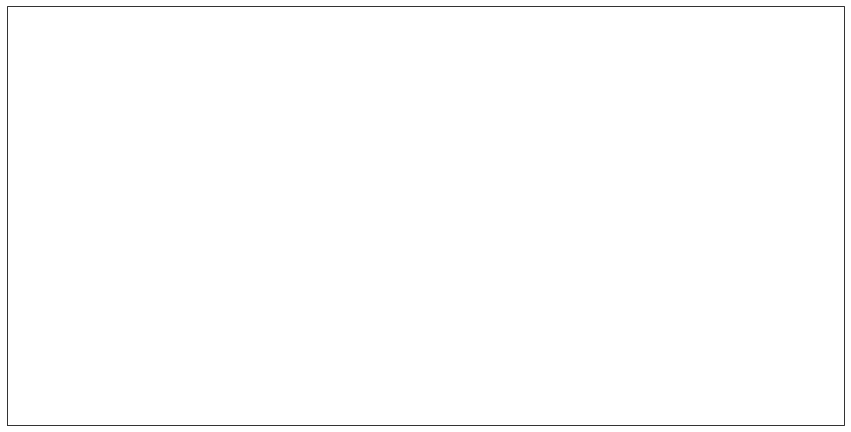

In [5]:
# Plot this to check the sanity of all the results

import cartopy.crs as ccrs
import cartopy.feature as cfeature

coastline = cfeature.NaturalEarthFeature('physical', 'coastline', '10m',
                           edgecolor=(1.0,0.8,0.0),
                           facecolor="none")

plt.figure(figsize=(15, 10))
ax = plt.subplot(111, projection=ccrs.PlateCarree())
ax.set_extent(map_extent)

ax.add_feature(coastline, edgecolor="black", linewidth=0.5, zorder=3)

plt.imshow(height, extent=map_extent, transform=ccrs.PlateCarree(),
           cmap='Greys', origin='lower', vmin=-5000., vmax=5000.)

ax.scatter(longitudes_in_degrees, latitudes_in_degrees, 
               c="black",  alpha=0.5,
               s=0.5, transform=ccrs.PlateCarree())

ax.scatter(longitudes_in_degrees[is_ocean], latitudes_in_degrees[is_ocean], 
               c="red",  alpha=0.25,
               s=0.5, transform=ccrs.PlateCarree())

In [6]:
## Obtain the age data and store in img format

age_dataset = "Data/age.3.6.nc"
age_data = xarray.open_dataset(age_dataset)
subs_data = age_data.sel(x=slice(-180,180, 1), y=slice(-90, 90, 1))

lons = subs_data.coords.get('x')
lats = subs_data.coords.get('y')
vals = subs_data['z']

x,y = np.meshgrid(lons.data, lats.data)
age = vals.data * 0.01 
age[np.isnan(age)] = -1.0

In [7]:
## Map heights/ages to the even-mesh grid points

def map_raster_to_mesh(mesh, raster):

    latitudes_in_radians  = mesh.lats
    longitudes_in_radians = mesh.lons 
    latitudes_in_degrees  = np.degrees(latitudes_in_radians) 
    longitudes_in_degrees = np.degrees(longitudes_in_radians)

    dlons = (longitudes_in_degrees + 180)
    dlats = latitudes_in_degrees + 90 

    ilons = raster.shape[0] * dlons / 360.0
    ilats = raster.shape[1] * dlats / 180.0

    icoords = np.stack((ilons, ilats))

    from scipy import ndimage

    mvals = ndimage.map_coordinates(raster, icoords , order=3, mode='nearest').astype(np.float)
    
    return mvals

In [8]:
height.shape

NameError: name 'height' is not defined

In [9]:
meshheights = map_raster_to_mesh(even_mesh, height.T)
meshages    = map_raster_to_mesh(even_mesh, age.T)

NameError: name 'height' is not defined

NameError: name 'map_extent' is not defined

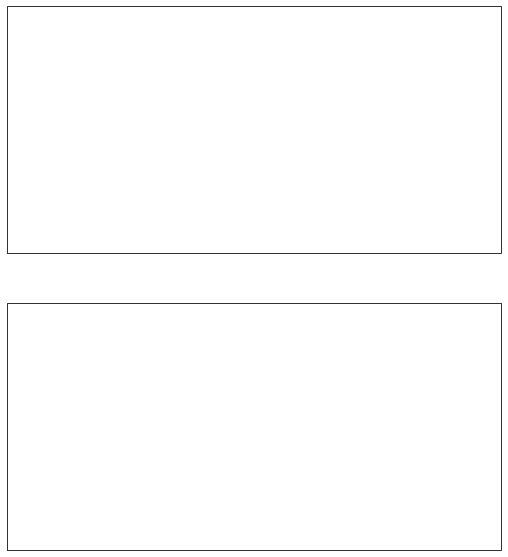

In [10]:
plt.figure(figsize=(10, 10))
ax1 = plt.subplot(211, projection=ccrs.PlateCarree())
ax2 = plt.subplot(212, projection=ccrs.PlateCarree())

ax1.set_extent(map_extent)

ax1.add_feature(coastline, edgecolor="black", linewidth=0.5, zorder=3)

m = ax1.scatter(longitudes_in_degrees, latitudes_in_degrees, 
               c=meshheights, cmap="terrain", vmin=-6000.0, vmax=6000.0,
               s=5.0, transform=ccrs.PlateCarree())

ax2.set_extent(map_extent)

ax2.add_feature(coastline, edgecolor="black", linewidth=0.5, zorder=3)

m = ax2.scatter(longitudes_in_degrees[is_ocean], latitudes_in_degrees[is_ocean], 
               c=meshages[is_ocean], cmap="RdYlBu", vmin=0.0, vmax=180.0,
               s=5.0, transform=ccrs.PlateCarree())

NameError: name 'meshages' is not defined

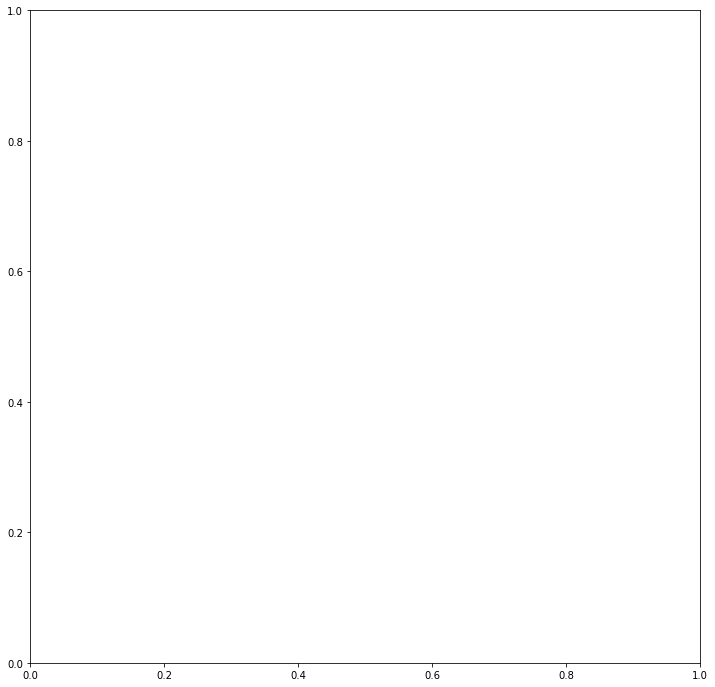

In [11]:
fig = plt.figure(figsize=(12, 12), facecolor="none")
ax  = plt.subplot(111)
ax.scatter(meshages[is_ocean], meshheights[is_ocean],s=0.1)
ax.set_xlim([0.0,150.0])